In [1]:
import pygetwindow as gw
from PIL import ImageGrab
import psutil
import os
import time
import threading
import cv2
import numpy as np
import keyboard
import pygetwindow as gw
import mss
import ctypes
import matplotlib.pyplot as plt
import pyautogui
from pynput.keyboard import Key, Controller
from directkeys import *

UP = 0xC8
LEFT = 0xCB
RIGHT = 0xCD
DOWN = 0xD0
TWO = 0x2
THREE = 0x3

In [18]:
def get_process_id_by_name(process_name):
    for process in psutil.process_iter(['pid', 'name']):
        if process.info['name'] == process_name:
            return process.info['pid']
    return None

def get_active_window_process_id():
    active_window = ctypes.windll.user32.GetForegroundWindow()
    process_id = ctypes.c_ulong(0)
    ctypes.windll.user32.GetWindowThreadProcessId(active_window, ctypes.byref(process_id))
    return process_id.value

def preprocess_image_with_canny(image):
    screenshot_np = np.array(image)

    processed_img = cv2.cvtColor(screenshot_np, cv2.COLOR_RGB2GRAY)
    processed_img = cv2.Canny(processed_img, threshold1=200, threshold2=300)

    return processed_img

def crop_image(np_image):
    height, width = np_image.shape
    x, y = 0, int(height / 3)

    cropped_image = np_image[y:y+height, x:x+width]

    return cropped_image

def delete_short_lines(np_image, min_length):
    canny_image = cv2.Canny(np_image, threshold1=100, threshold2=200)

    # Визначимо розмір ядра для діляції
    kernel_size = 3
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Застосуємо діляцію для збільшення розміру ліній
    thick_lines_image = cv2.dilate(canny_image, kernel, iterations=1)

    # Показати зображення з товстими лініями
    # plt.imshow(cv2.cvtColor(thick_lines_image, cv2.COLOR_BGR2RGB))
    # plt.show()

    contours, _ = cv2.findContours(thick_lines_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Видалення ліній, які коротші за min_length пікселів
    filtered_image = thick_lines_image.copy()

    for contour in contours:
        if cv2.arcLength(contour, True) < min_length:
            cv2.drawContours(filtered_image, [contour], -1, 0, -1)

    return filtered_image

def draw_black_bbox(np_image, x_min, y_min, x_max, y_max):
    for i in range(x_min, x_max):
        for j in range(y_min, y_max):
            np_image[i][j] = 0

def distance_to_first_white_pixel(np_image, start_point, dx, dy):
    x, y = start_point
    while 0 <= x < np_image.shape[1] and 0 <= y < np_image.shape[0]:
        if np_image[int(y), int(x)] == 255:
            break

        x += dy
        y += dx

    # Знайдена точка, де перший білий піксель перетинається з променем
    end_point = (int(x), int(y))
    # Знайдена відстань
    distance = np.sqrt((end_point[0] - start_point[0])**2 + (end_point[1] - start_point[1])**2)

    return end_point, distance

optimization:

In [62]:
process_name = "Trackmania.exe"  # Назва процесу, для якого ви хочете отримати ідентифікатор
process_id = get_process_id_by_name(process_name)

printscreen_array = []

while True:
    active_process_id = get_active_window_process_id()  

    if process_id == active_process_id:

        print("screenshot")

        printscreen =  ImageGrab.grab()
        printscreen_array.append(printscreen)
        time.sleep(0.5)
        


screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot
screenshot


KeyboardInterrupt: 

In [150]:
def test_first_approach(image):
    start_time = time.time()
    
    processed_img = preprocess_image_with_canny(image)

    cropped_image = crop_image(processed_img)

    filtered_image = delete_short_lines(cropped_image, 500)

    draw_black_bbox(filtered_image, 400, 1000, 954, 1550)

    start_point = (1280, 700)
    dx = -1
    max_distance = 0
    final_point = ()
    final_angle = ()

    # plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))

    for dy in range(-20, 21, 5):
        end_point, distance = distance_to_first_white_pixel(filtered_image, start_point, dx, dy / 50)
        x_end, y_end = end_point
        # plt.scatter(x_end, y_end, color='green', marker='o', s=20)

        if distance > max_distance:
            max_distance = distance
            final_point = end_point
            final_angle = (dx, dy)

    _, angle = final_angle

    x_start, y_start = start_point

    # plt.show()
    end_time = time.time()
    print("approach 1 execute time:", end_time - start_time)


def test_second_approach(image):
    start_time = time.time()
    
    screenshot_np = np.array(image)
    gray_image = cv2.cvtColor(screenshot_np, cv2.COLOR_RGB2GRAY)

    height, width = gray_image.shape

    crop_height = int(0.4 * height)

    cropped_image = gray_image[crop_height:, :]

    _, thresholded_image = cv2.threshold(cropped_image, 250, 255, cv2.THRESH_BINARY)
    
    kernel_size = 9
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Застосування діляції
    smoothed_image = cv2.dilate(thresholded_image, kernel, iterations=1)

    new_size = (100, 100)
    resized_image = cv2.resize(smoothed_image, new_size)

    resized_image_copy = resized_image.copy()
    width, height = new_size
    final_kernel_size = 3
    for i in range(final_kernel_size, height - final_kernel_size):
        for j in range(final_kernel_size, width - final_kernel_size):
            if resized_image[i][j] == 255 and (resized_image[i][j - 1] == 0 or resized_image[i][j - 2] == 0) and (resized_image[i][j + 1] == 0 or resized_image[i][j + 2] == 0):
                resized_image_copy[i][j] = 0

    kernel_size = 9
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Застосування діляції
    smoothed_image = cv2.dilate(resized_image, kernel, iterations=1)

    end_time = time.time()
    print("approach 2 execute time:", end_time - start_time)
    # Відображення згладженого зображення
    plt.imshow(resized_image, cmap='gray')
    plt.show()

approach 1 execute time: 0.11458182334899902
approach 2 execute time: 0.028998136520385742


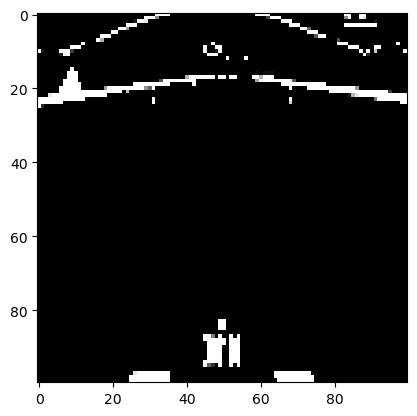

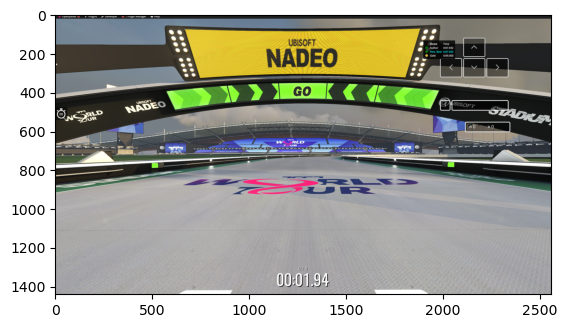

approach 1 execute time: 0.12152647972106934
approach 2 execute time: 0.028998136520385742


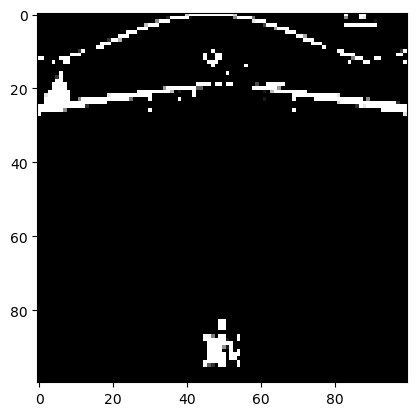

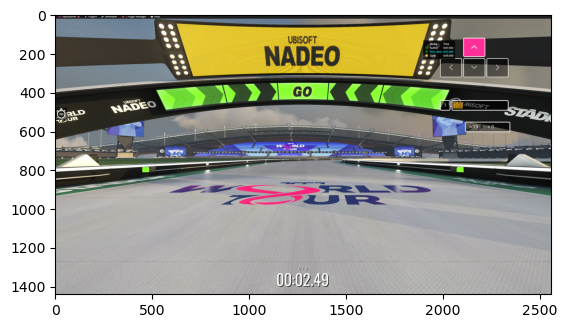

approach 1 execute time: 0.10937619209289551
approach 2 execute time: 0.029894590377807617


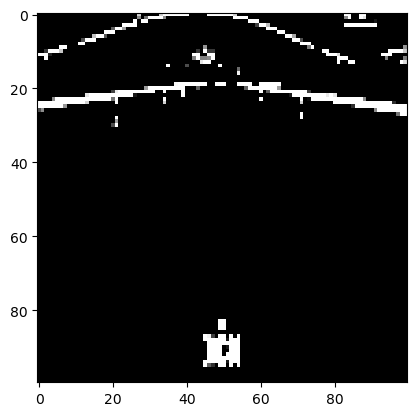

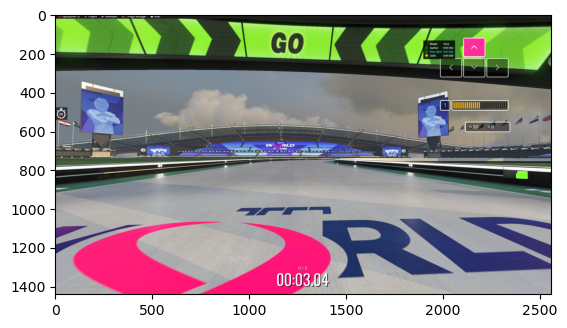

approach 1 execute time: 0.1293506622314453
approach 2 execute time: 0.031998395919799805


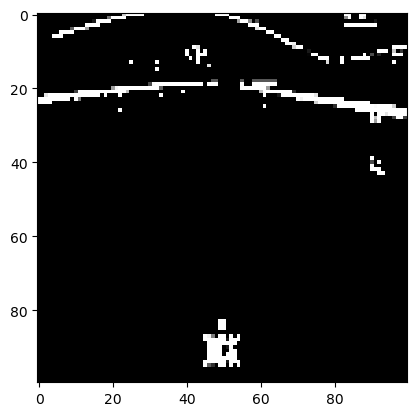

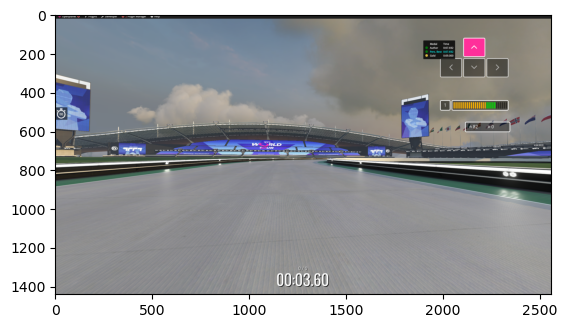

approach 1 execute time: 0.15141963958740234
approach 2 execute time: 0.03200364112854004


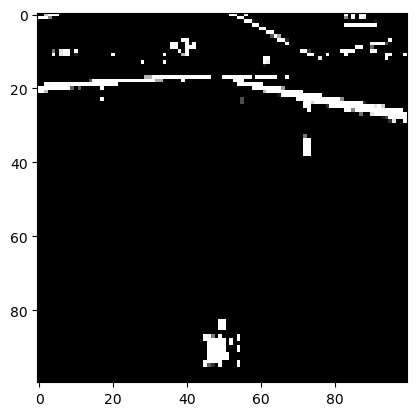

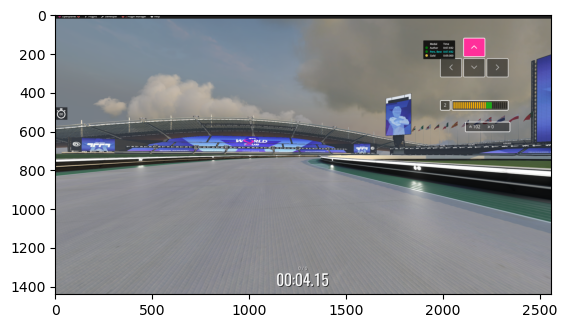

approach 1 execute time: 0.12447571754455566
approach 2 execute time: 0.029000043869018555


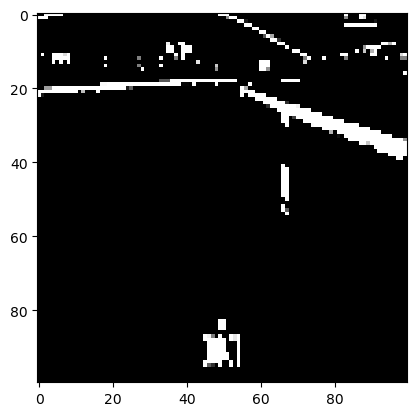

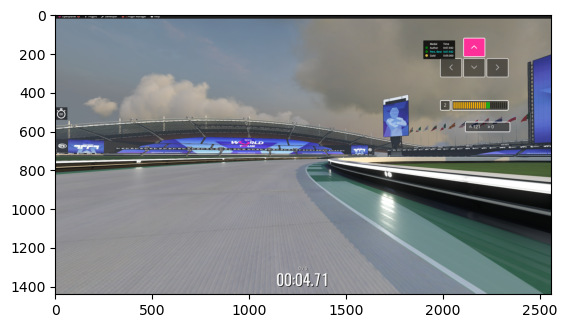

approach 1 execute time: 0.11401176452636719
approach 2 execute time: 0.0323941707611084


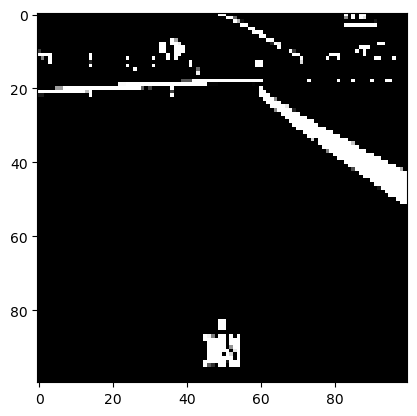

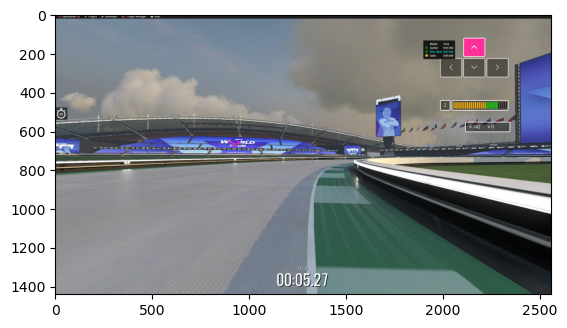

approach 1 execute time: 0.15674185752868652
approach 2 execute time: 0.03200125694274902


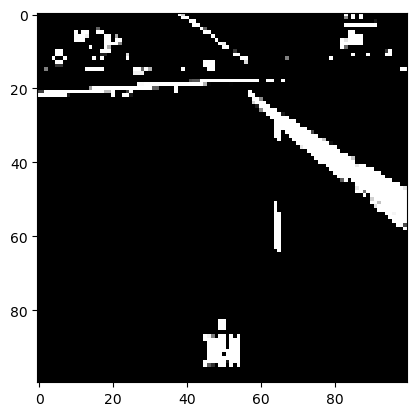

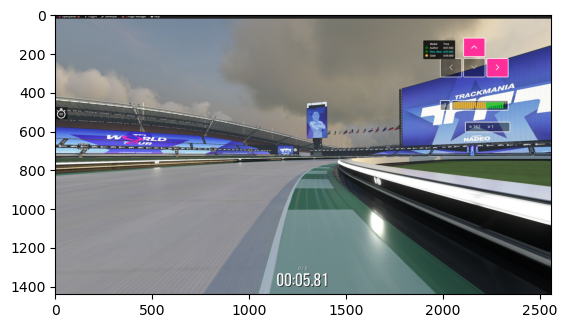

approach 1 execute time: 0.11573910713195801
approach 2 execute time: 0.03125810623168945


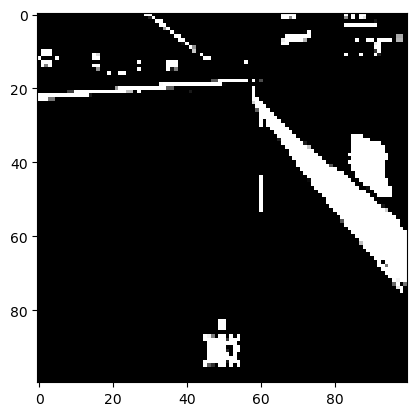

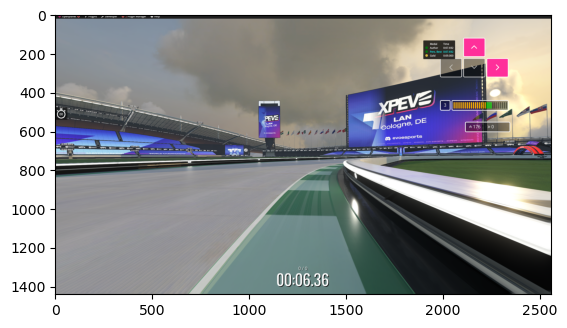

approach 1 execute time: 0.11174702644348145
approach 2 execute time: 0.028270721435546875


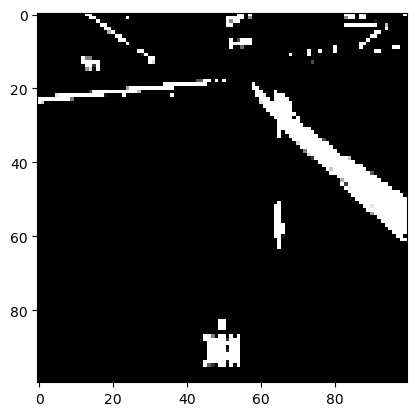

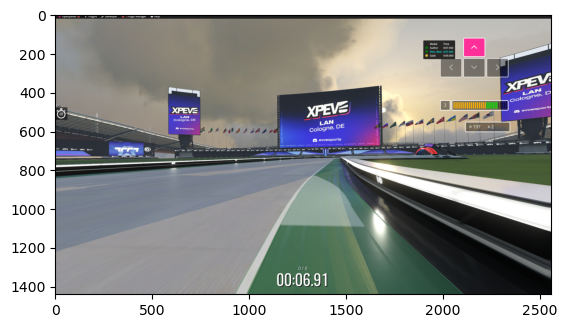

approach 1 execute time: 0.12351512908935547
approach 2 execute time: 0.030999422073364258


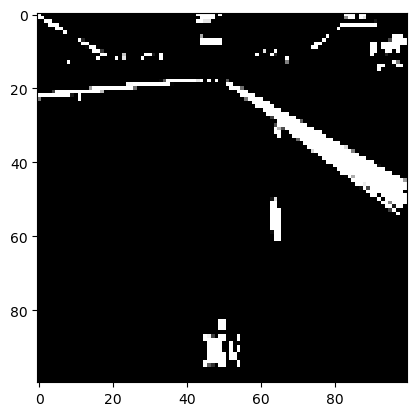

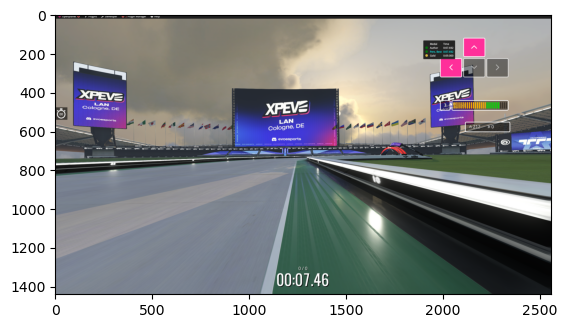

approach 1 execute time: 0.13864827156066895
approach 2 execute time: 0.030531883239746094


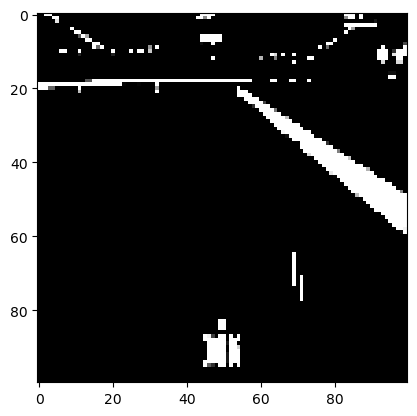

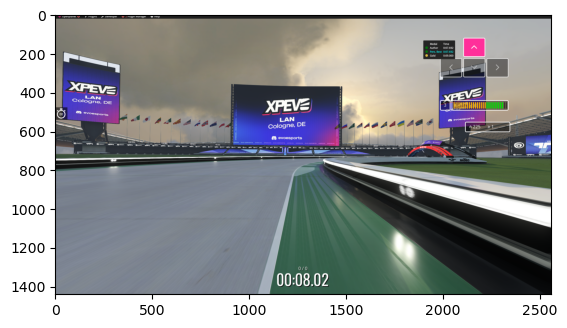

approach 1 execute time: 0.13603663444519043
approach 2 execute time: 0.03899693489074707


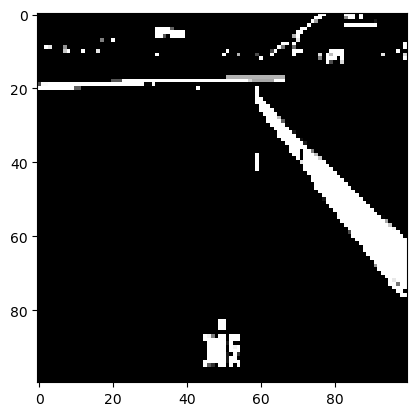

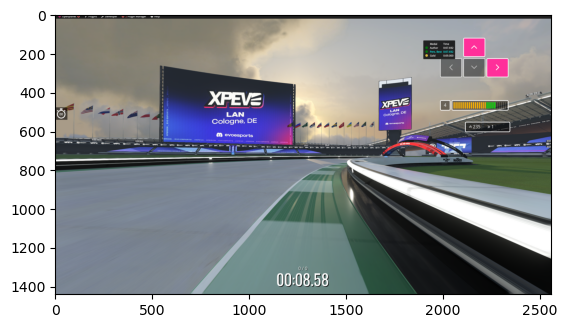

approach 1 execute time: 0.15999913215637207
approach 2 execute time: 0.030002117156982422


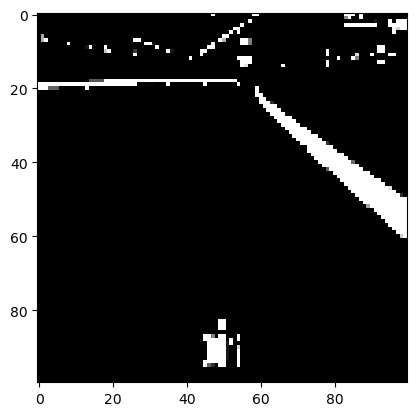

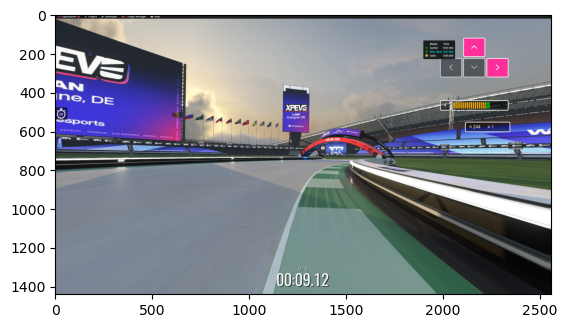

approach 1 execute time: 0.1215665340423584
approach 2 execute time: 0.030729293823242188


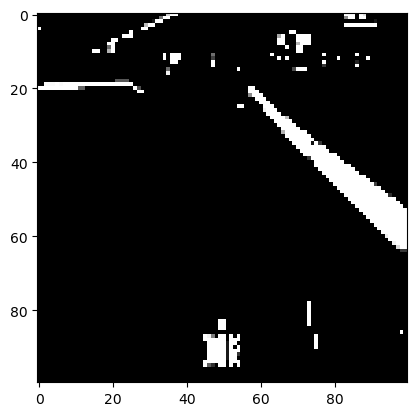

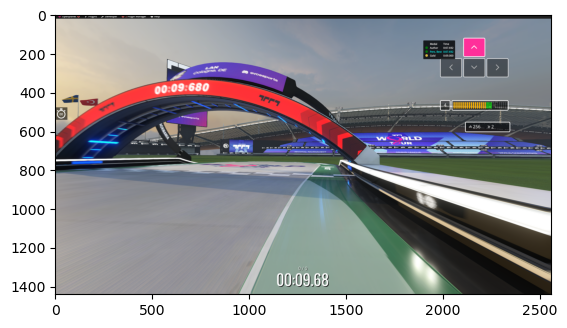

approach 1 execute time: 0.11484050750732422
approach 2 execute time: 0.030025720596313477


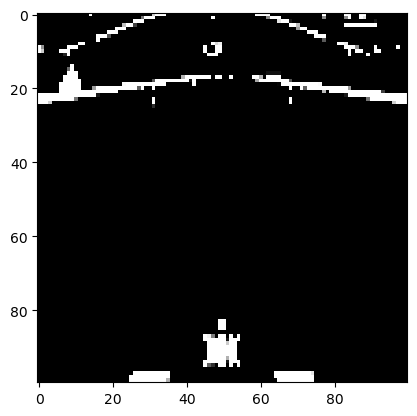

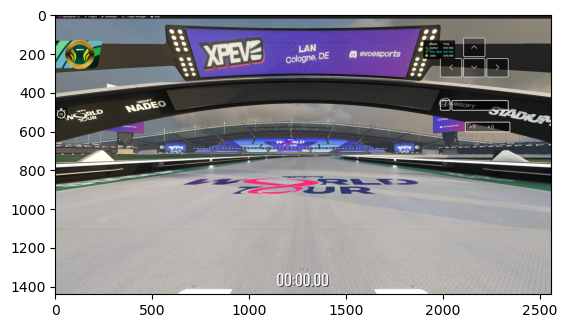

approach 1 execute time: 0.17056608200073242
approach 2 execute time: 0.03299999237060547


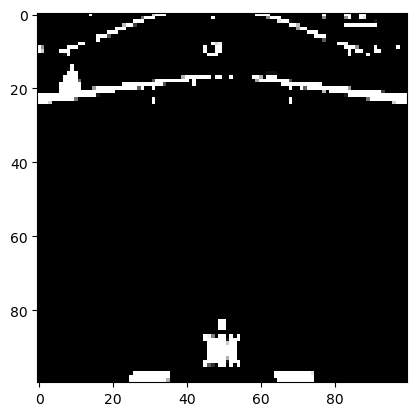

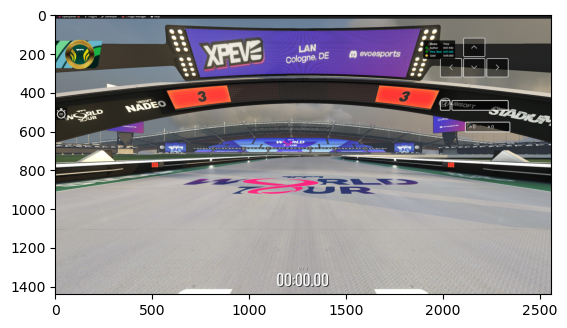

approach 1 execute time: 0.11899971961975098
approach 2 execute time: 0.031008243560791016


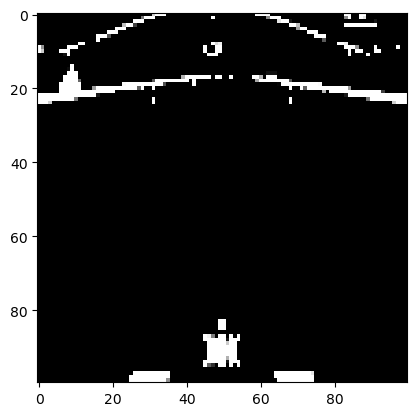

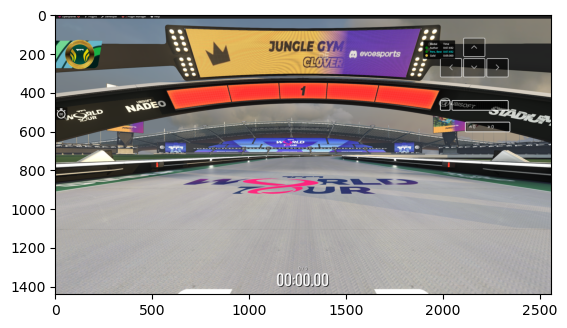

approach 1 execute time: 0.11301374435424805
approach 2 execute time: 0.028364181518554688


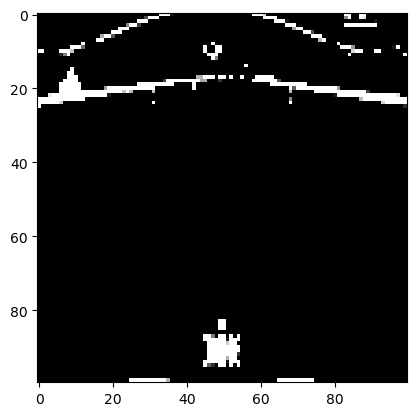

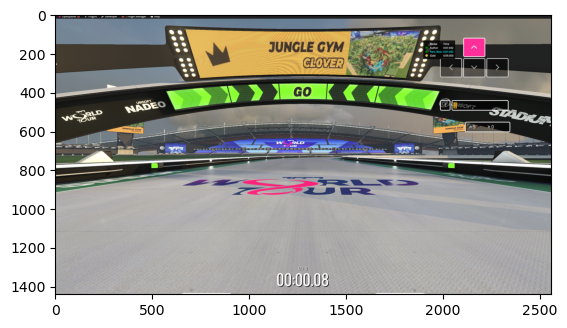

approach 1 execute time: 0.1288769245147705
approach 2 execute time: 0.02899765968322754


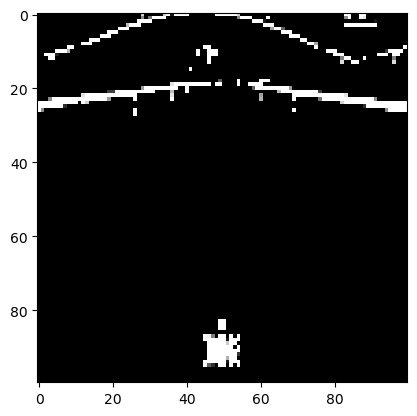

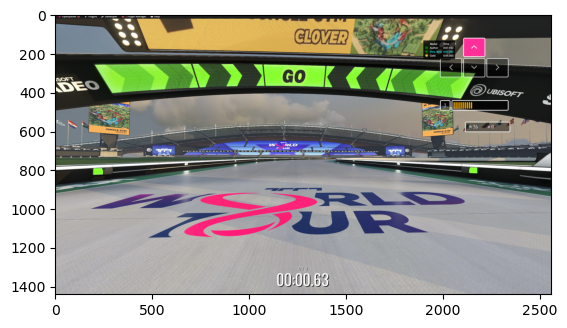

approach 1 execute time: 0.11034297943115234
approach 2 execute time: 0.029005765914916992


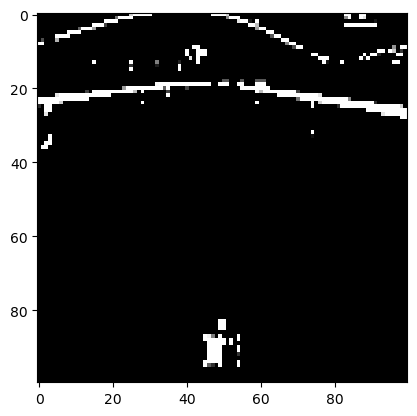

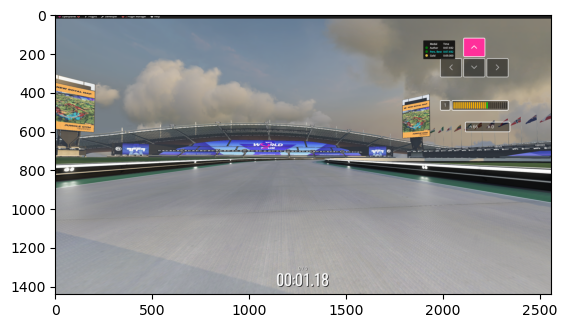

approach 1 execute time: 0.12760090827941895
approach 2 execute time: 0.030001163482666016


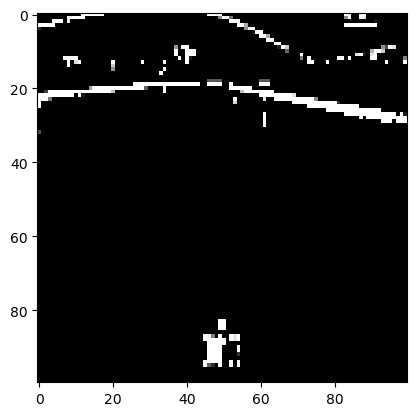

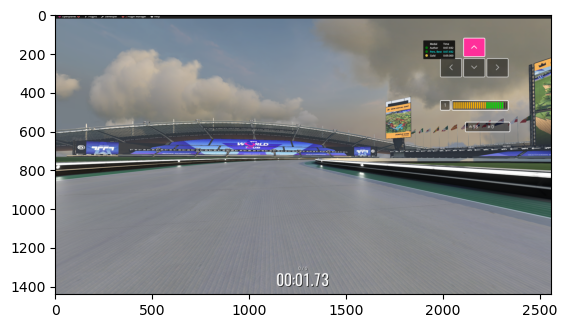

approach 1 execute time: 0.13835358619689941
approach 2 execute time: 0.030515432357788086


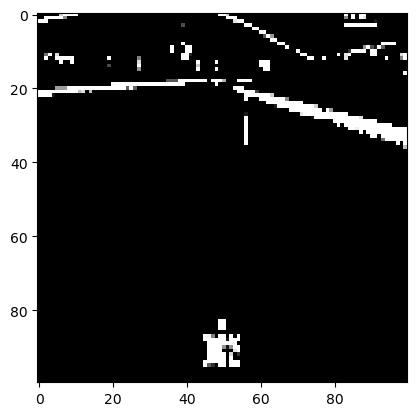

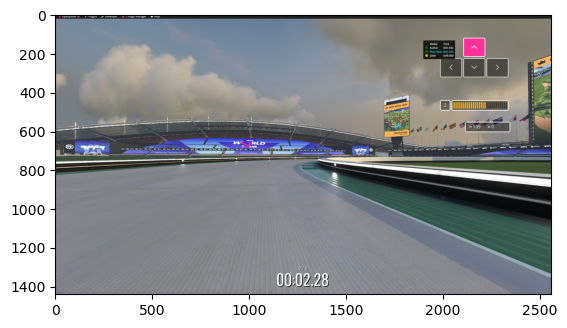

approach 1 execute time: 0.12889385223388672
approach 2 execute time: 0.04099535942077637


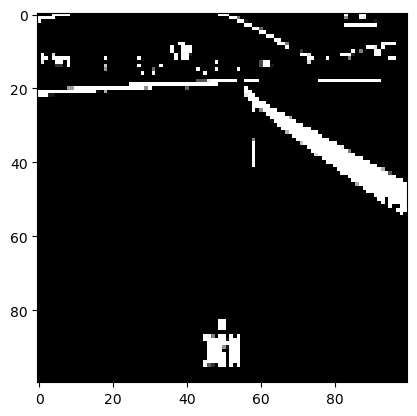

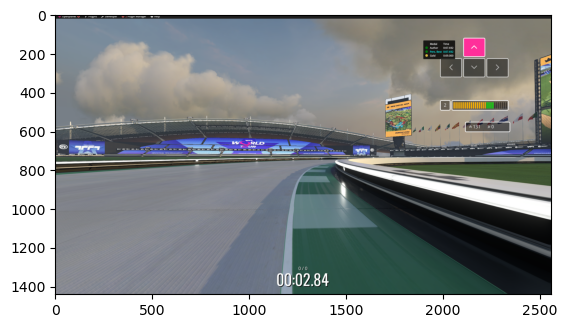

approach 1 execute time: 0.14473867416381836
approach 2 execute time: 0.030002593994140625


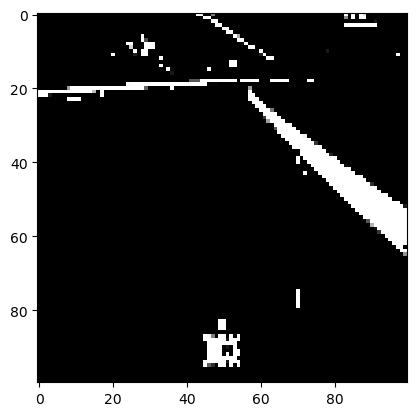

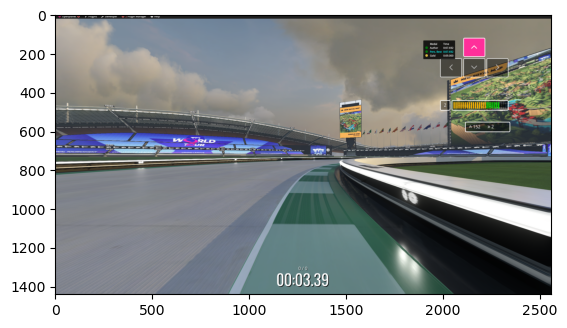

approach 1 execute time: 0.15437650680541992
approach 2 execute time: 0.03299832344055176


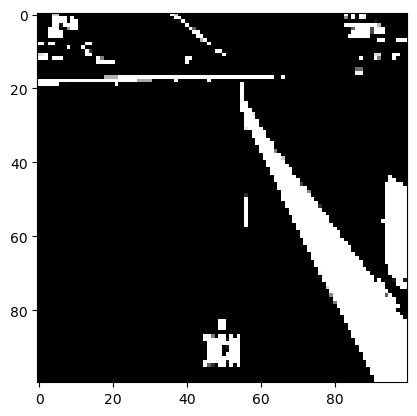

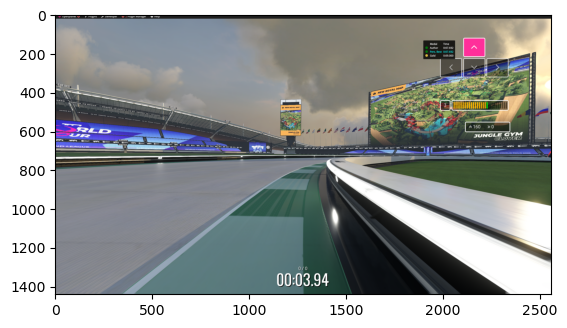

approach 1 execute time: 0.13599562644958496
approach 2 execute time: 0.029000043869018555


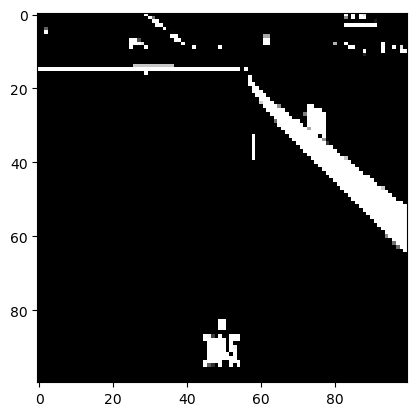

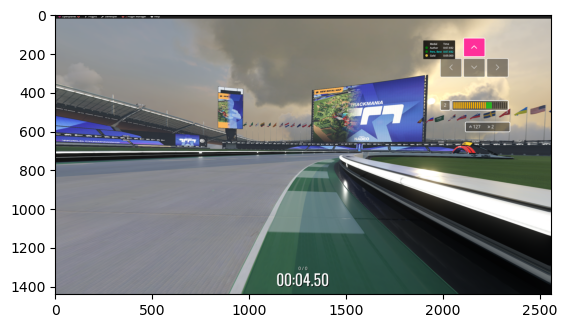

approach 1 execute time: 0.1355435848236084
approach 2 execute time: 0.03251147270202637


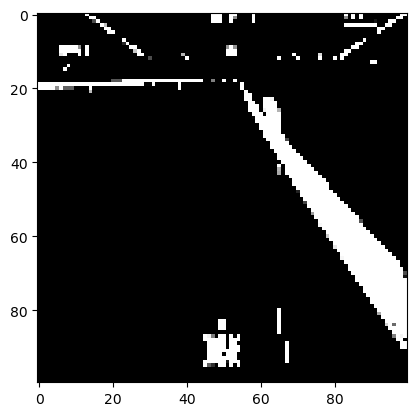

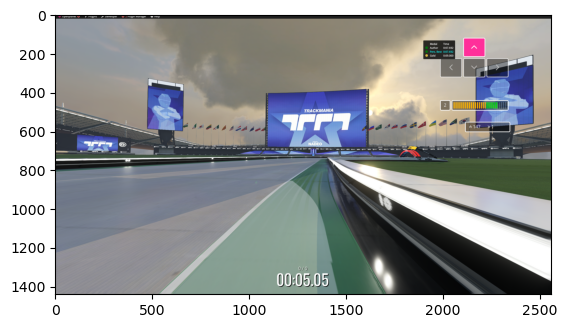

approach 1 execute time: 0.12164187431335449
approach 2 execute time: 0.030998945236206055


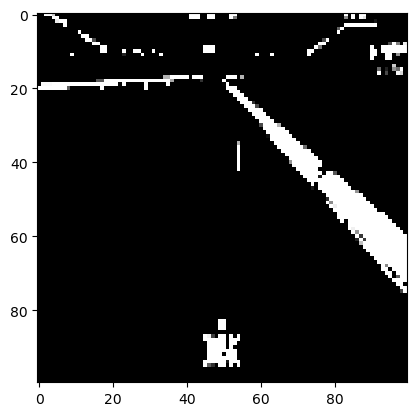

KeyboardInterrupt: 

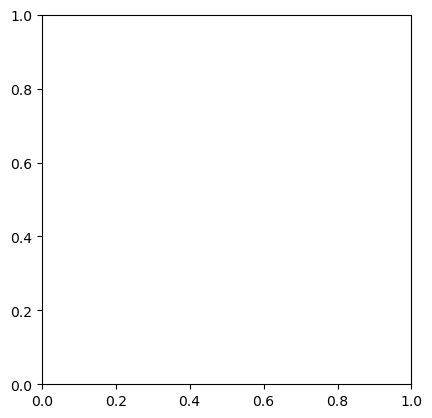

In [151]:
for screenshot in printscreen_array:
    test_first_approach(screenshot)
    test_second_approach(screenshot)
    
    plt.imshow(screenshot)
    plt.show()